In [1]:
# To ignore deprecated warnings
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec 관련 모델을 제공해주는 library  
import nltk
from nltk.corpus import movie_reviews # corpus 를 가져오는 용도 
from sklearn.manifold import TSNE # 시각화를 위한 TSNE 사용 
from sklearn.metrics import accuracy_score # accuracy score 를 계산하기 위한 metric 라이브러리 불러오기 
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import sentencepiece as spm
from torch.utils import data # pytorch data class 
import torch.nn as nn # pytorch neural network 불러오기 
import torch.nn.utils.rnn as rnn_utils # rnn utils
import torch

import pickle

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Word embedding (CBOW & Skip-Gram)



```
# This is formatted as code
```

![대체 텍스트](./figures/embedding.png)

![대체 텍스트](./figures/w2vec_1.png)

In [2]:
# 파라메터값 지정
num_features = 300 # 임베딩 벡터 사이즈
negative = 10 # negative sampling할 단어 수
min_word_count = 10 # 한 문장에 대한 최소 문자 수
window = 5 # context window 사이즈
downsampling = 0.75 # 단어의 빈도수가 지나치게 높은 단어에 대해 빈도수를 낮춤
epoch = 5 # epoch 수

In [3]:
# preparing data
sentences = []
pos_data = open("./pos_train.txt").readlines()
neg_data = open("./neg_train.txt").readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(line.strip().split(' '))  # `sentences` has multiple sentences and each sentence is splitted by space

In [4]:
# skip-gram 모델 학습
skip_gram = word2vec.Word2Vec(sentences,
                              sg = 1, # skip-gram
                              negative=negative,
                              size=num_features, 
                              min_count=min_word_count,
                              window=window,
                              sample=downsampling,
                              iter=epoch)

# CBOW 모델 학습
CBOW = word2vec.Word2Vec(sentences,
                         sg = 0, # CBOW
                         negative=negative,
                         size=num_features, 
                         min_count=min_word_count,
                         window=window,
                         sample=downsampling,
                         iter=epoch)

2020-08-10 16:19:55,382 : INFO : collecting all words and their counts
2020-08-10 16:19:55,382 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-10 16:19:55,409 : INFO : PROGRESS: at sentence #10000, processed 239982 words, keeping 20149 word types
2020-08-10 16:19:55,435 : INFO : PROGRESS: at sentence #20000, processed 475267 words, keeping 28557 word types
2020-08-10 16:19:55,462 : INFO : PROGRESS: at sentence #30000, processed 718530 words, keeping 35153 word types
2020-08-10 16:19:55,487 : INFO : PROGRESS: at sentence #40000, processed 942659 words, keeping 40650 word types
2020-08-10 16:19:55,512 : INFO : PROGRESS: at sentence #50000, processed 1164181 words, keeping 45109 word types
2020-08-10 16:19:55,536 : INFO : PROGRESS: at sentence #60000, processed 1387734 words, keeping 49141 word types
2020-08-10 16:19:55,544 : INFO : collected 50290 word types from a corpus of 1453943 raw words and 62966 sentences
2020-08-10 16:19:55,544 : INFO : Loading 

##  Training result

In [5]:
skip_gram.wv.most_similar("man") # skip-gram 모델을 이용하여 'man'에 가장 유사한 단어 추출

2020-08-10 16:21:43,198 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.7323310971260071),
 ('boy', 0.6924585103988647),
 ('person', 0.6766387224197388),
 ('guy', 0.6756831407546997),
 ('girl', 0.6741845011711121),
 ('doctor', 0.6732752919197083),
 ('teenager', 0.6703862547874451),
 ('kid', 0.650365948677063),
 ('businessman', 0.6435887813568115),
 ('lady', 0.6330604553222656)]

In [6]:
CBOW.wv.most_similar("man") # CBOW 모델을 이용하여 'man'에 가장 유사한 단어 추출

2020-08-10 16:21:45,743 : INFO : precomputing L2-norms of word weight vectors


[('woman', 0.9401863813400269),
 ('girl', 0.9065372943878174),
 ('boy', 0.867948055267334),
 ('child', 0.8132514953613281),
 ('kid', 0.7931815385818481),
 ('person', 0.7771292924880981),
 ('doctor', 0.7711237668991089),
 ('guy', 0.7667837142944336),
 ('cop', 0.7661964893341064),
 ('lawyer', 0.7528604865074158)]

In [8]:
vector = skip_gram["king"] - skip_gram["man"] + skip_gram["woman"]
skip_gram.wv.similar_by_vector(vector, topn=10, restrict_vocab=None)

[('king', 0.7408465147018433),
 ('jessica', 0.6389225125312805),
 ('co-star', 0.6326408386230469),
 ('sam', 0.6301625370979309),
 ('neal', 0.6210400462150574),
 ('kennedy', 0.6201689839363098),
 ('queen', 0.6200265884399414),
 ('kingpin', 0.6183465719223022),
 ('reed', 0.6160469055175781),
 ('stone', 0.6146937608718872)]

In [9]:
def render_TSNE(vocab, word_emb):
    """
    TSNE를 이용한 word2vec 시각화 (t-Stochastic Nearest Neighbor)
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) #TSNE 시각화를 위한 initialization
    _tsne = tsne.fit_transform(word_emb) # TSNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에대해 단어 labeling

    plt.show()

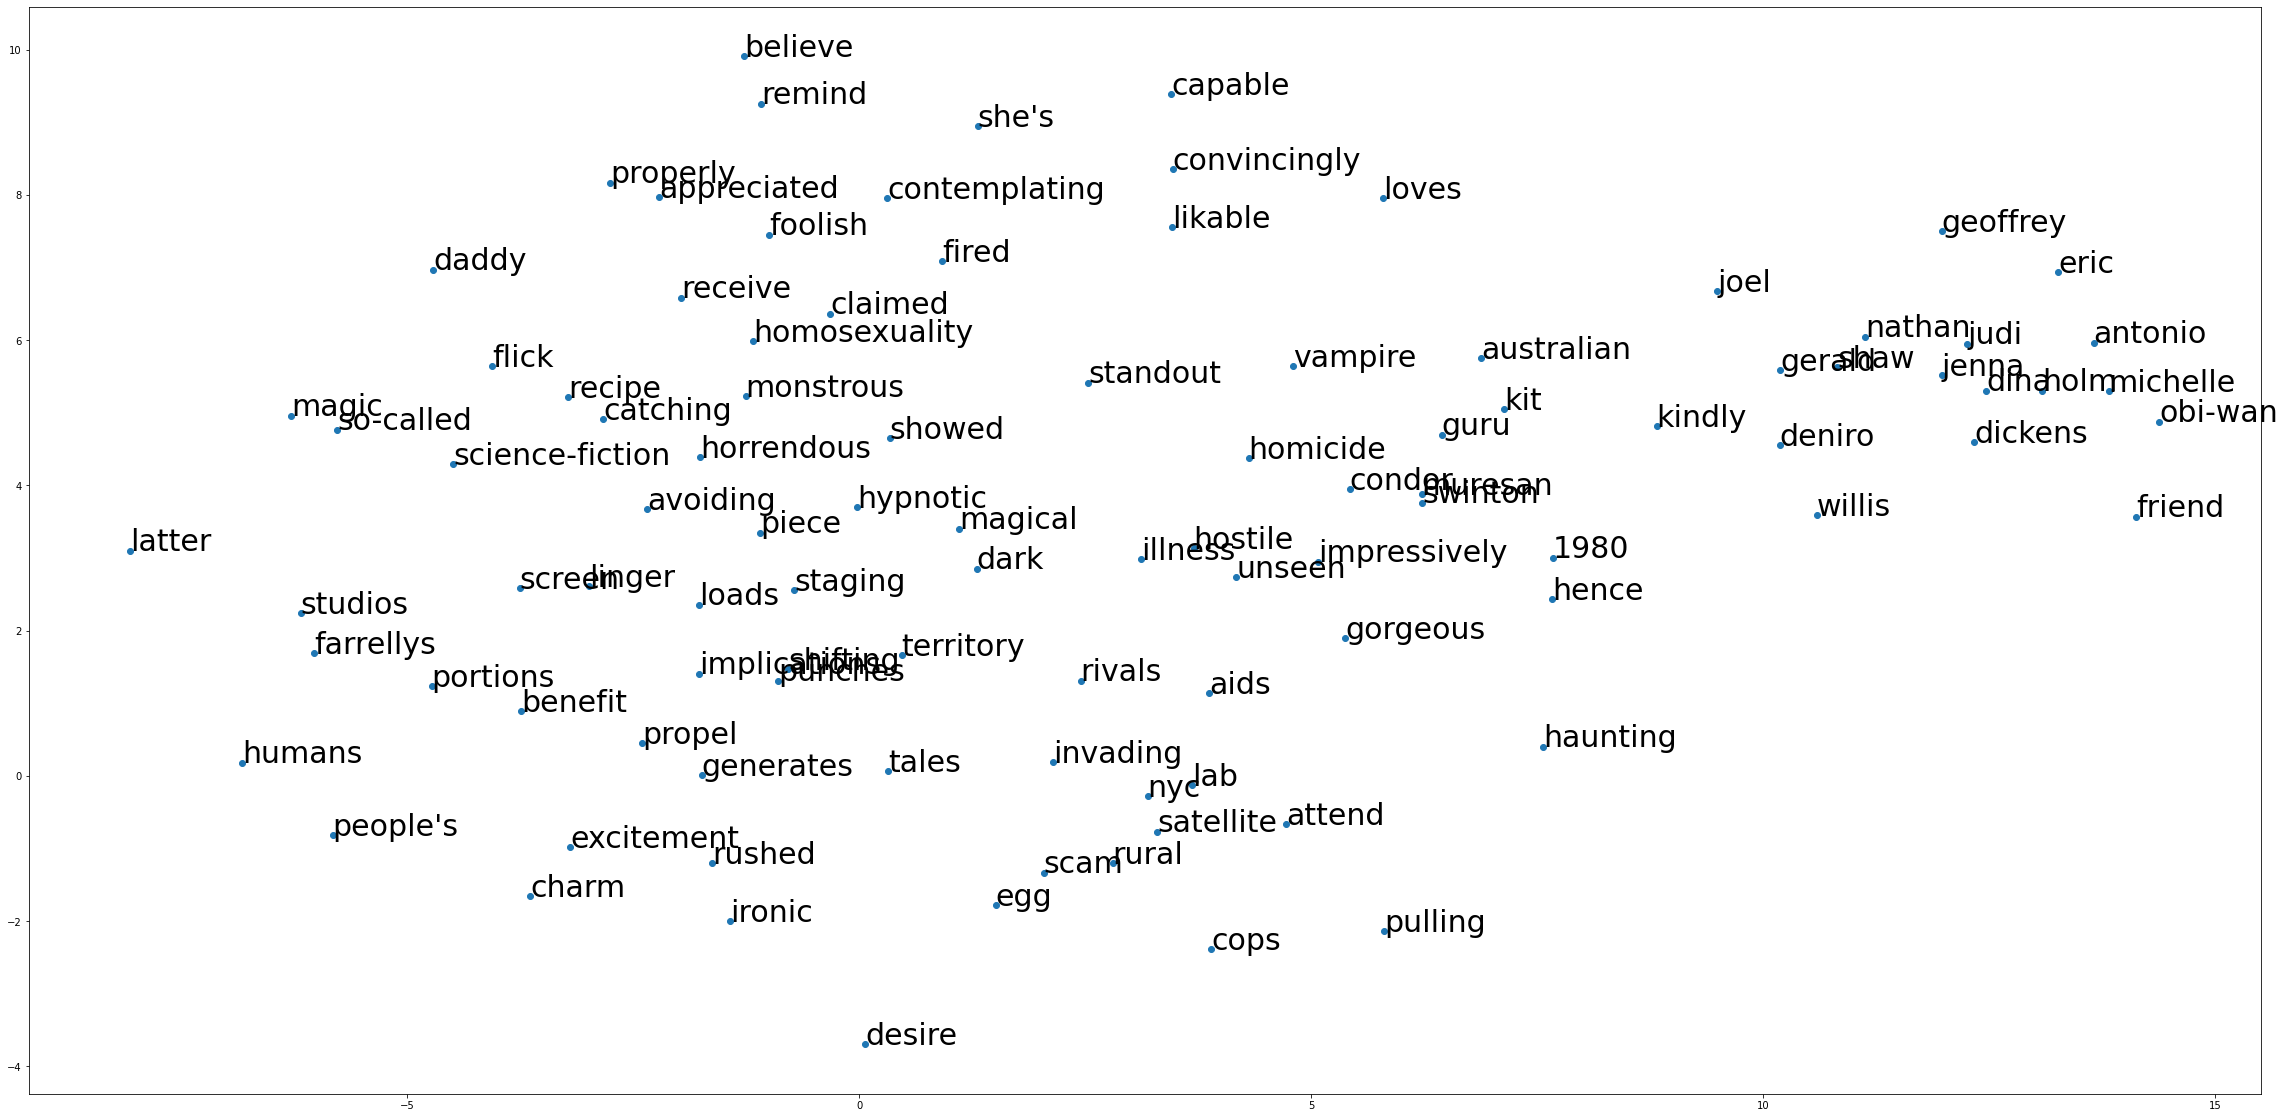

In [10]:
# Skip-gram 시각화(TSNE)
vocab = list(skip_gram.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

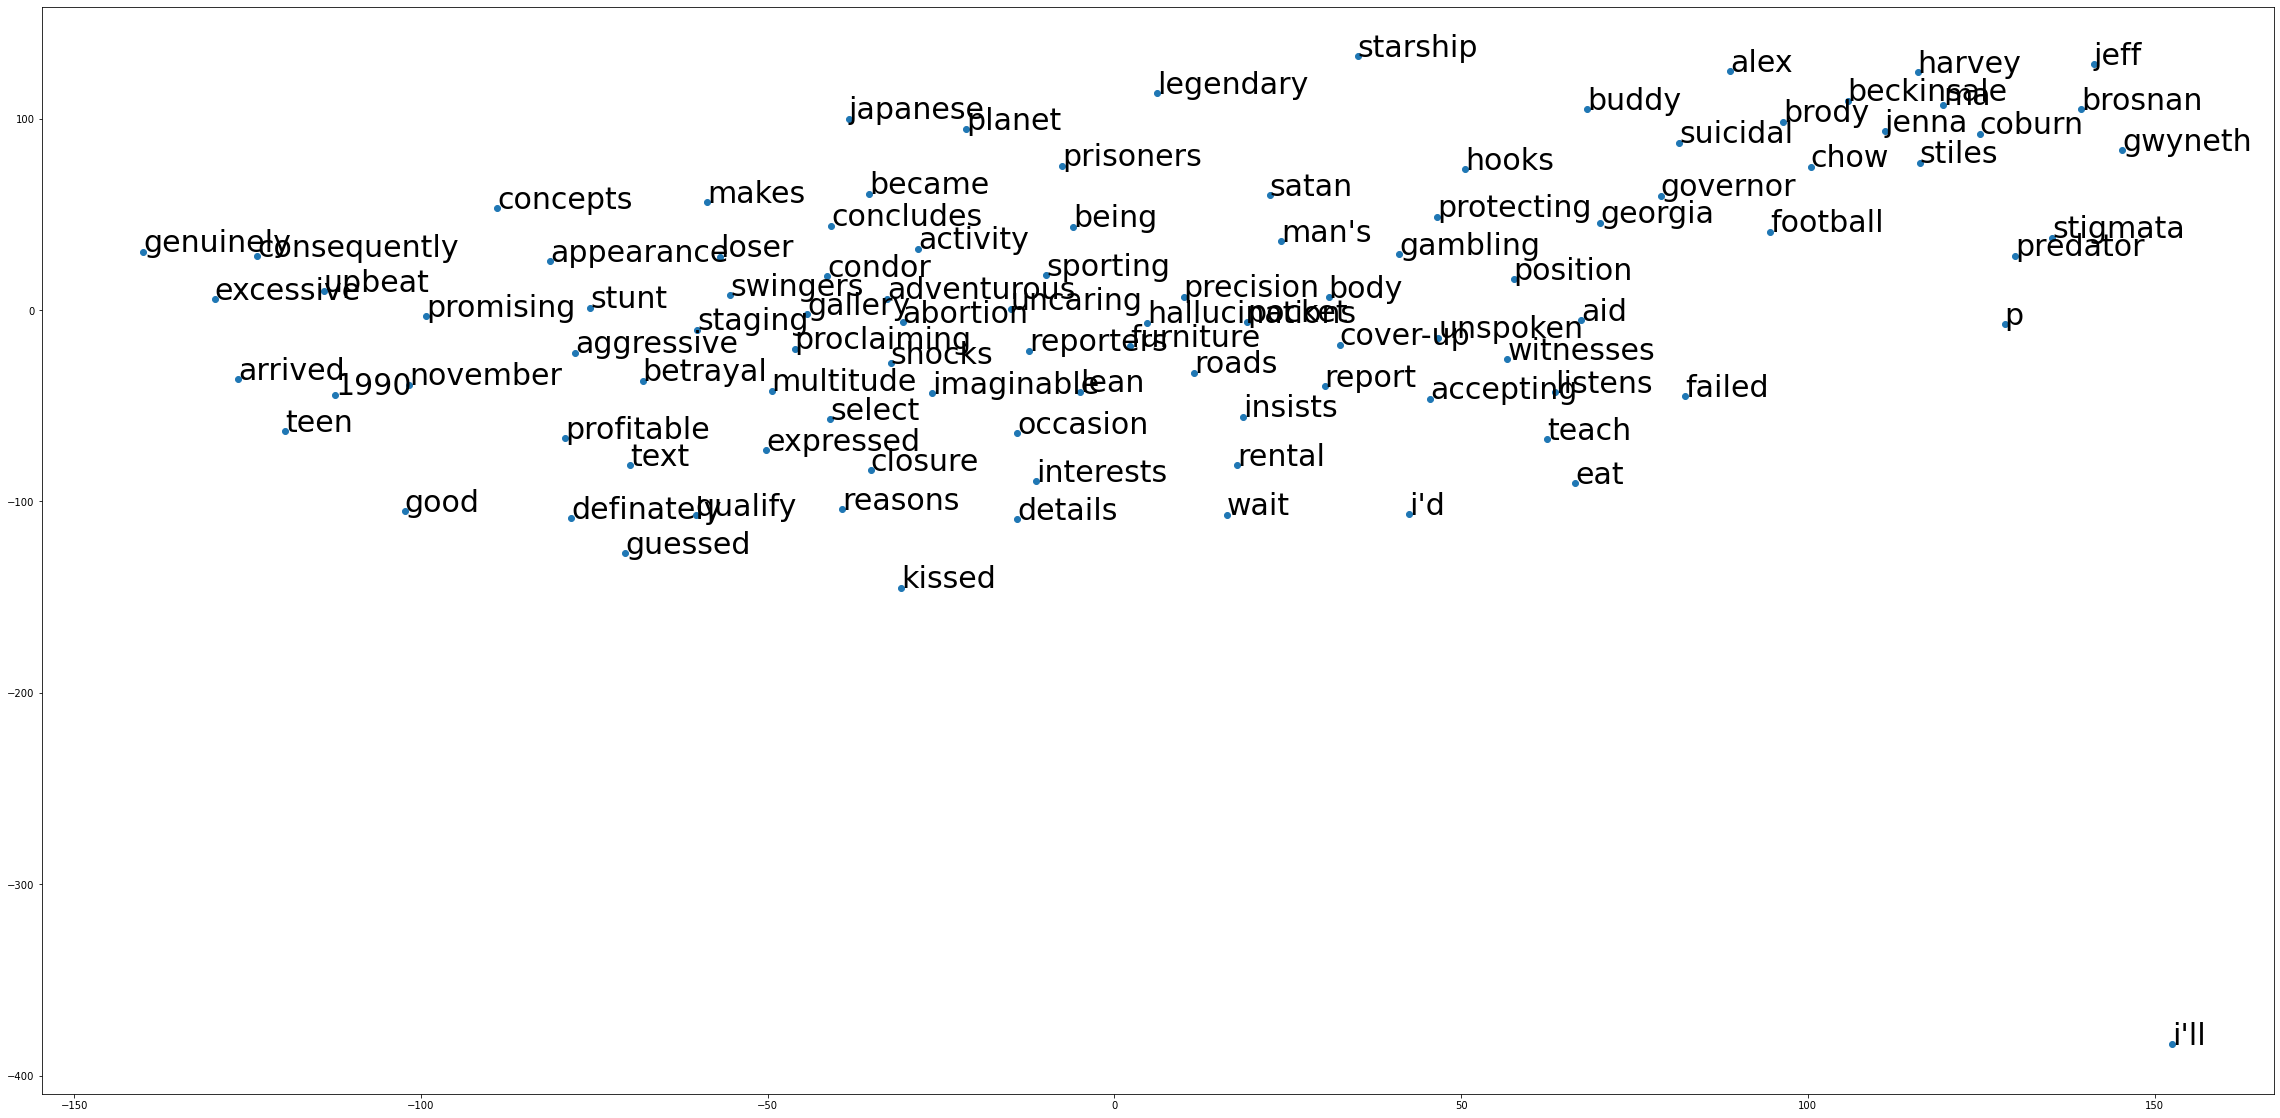

In [11]:
# CBOW 시각화(TSNE)
vocab = list(CBOW.wv.vocab) # vocab list 불러오기
random_vocab = random.sample(vocab,k=100) #100개의 임의 단어를 랜덤 샘플링
word_emb = skip_gram[random_vocab] # 샘플링된 단어에 대해 학습된 임베딩 벡터 불러오기
render_TSNE(random_vocab, word_emb) # TSNE 시각화

# (Optional) SentencePiece model

In [ ]:
spm.SentencePieceTrainer.train(input="./train.txt", model_prefix='m', vocab_size=10000, user_defined_symbols=['[CLS]', '[SEP]'])

sp = spm.SentencePieceProcessor(model_file='./m.model')
sentences = []
pos_data = open("./pos_train.txt").readlines()
neg_data = open("./neg_train.txt").readlines()
data_ = pos_data + neg_data
for line in data_:
    sentences.append(sp.encode(line.strip()))